In [1]:
%pylab inline
import os
import glob
import xlens
import astropy.table as astTable
import multiprocessing as mp
import gc
import time

import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [13]:
success = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/success.fits")
tracts = np.unique(success["tract"])

In [33]:
slist = []
for tract in tracts:
    msk = (success["tract"] == tract)
    pp = success[msk]["patch"]
    patches = [str(ss) for ss in pp]
    ss = "(tract=%s AND patch in (" % tract
    ss += ", ".join(patches)
    ss += "))"
    slist.append(ss)
print("\n OR ".join(slist))

(tract=8279 AND patch in (67))
 OR (tract=8280 AND patch in (70))
 OR (tract=8281 AND patch in (66))
 OR (tract=8282 AND patch in (75, 79, 63, 70))
 OR (tract=8283 AND patch in (76))
 OR (tract=8284 AND patch in (64))
 OR (tract=8285 AND patch in (68))
 OR (tract=8520 AND patch in (56, 11, 37, 69, 60))
 OR (tract=8521 AND patch in (51, 31, 8, 58, 5))
 OR (tract=8522 AND patch in (51, 71, 32, 75, 6, 2, 4, 37, 49, 44))
 OR (tract=8523 AND patch in (54, 52))
 OR (tract=8524 AND patch in (51, 32, 15, 58, 36, 55, 70))
 OR (tract=8525 AND patch in (1, 71, 17, 58, 23, 36))
 OR (tract=8526 AND patch in (50, 17, 4, 79, 33))
 OR (tract=8762 AND patch in (21, 31, 30, 49, 36))
 OR (tract=8763 AND patch in (48, 77, 20, 17))
 OR (tract=8764 AND patch in (13, 42, 28, 57, 70))
 OR (tract=8765 AND patch in (19, 48, 67, 31, 25, 49, 46))
 OR (tract=8766 AND patch in (11, 31, 25, 12, 79))
 OR (tract=8767 AND patch in (40, 11, 64, 33, 52))
 OR (tract=8768 AND patch in (20, 69, 39, 28, 44, 52))
 OR (tract=9

In [4]:
data_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_sim/dm_catalog/20250304T134707Z/sim_0_rot0_Coadd_meas/"
tract_dir_list = glob.glob(data_dir + "/*")
ndata = 0
data_all = []
failed_all = []
for tract_dir in tract_dir_list:
    sub_dirs = glob.glob(tract_dir + "/*")
    for patch_dir in sub_dirs:
        patch = int(patch_dir.split("/")[-1])
        tract = int(patch_dir.split("/")[-2])
        if len(glob.glob(patch_dir+ "/*")) < 5:
            ss = "grizy"
            for d in glob.glob(patch_dir+ "/*"):
                band = d.split("/")[-1]
                ss = ss.replace(band, "")
            for _ in ss:
                failed_all.append((tract, patch, _)) 
            continue
        data_all.append((tract, patch)) 
        ndata += 1
        
failed_all = np.array(failed_all, dtype=[("tract", "<i4"), ("patch", "<i4"), ("field", "U10")])
data_all = np.array(data_all, dtype=[("tract", "<i4"), ("patch", "<i4")])
tracts = np.unique(data_all["tract"])

pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/success.fits", data_all)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/failure.fits", failed_all)

In [23]:
data_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_sim/dm_catalog/20250304T134707Z/sim_0_rot0_Coadd_meas/"
output_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode00/"

def process_tract(tract):
    """Process all patches for a given tract."""
    output_path = os.path.join(output_dir, f"{tract}.fits")
    # Skip if the file already exists
    if os.path.isfile(output_path):
        print(f"Skipping {tract} (already processed)")
        return

    patches = data_all["patch"][data_all["tract"] == tract]
    results = {  # Initialize storage
        "patches": [], "inds": [], "fwhm_sim_i": [], "var_sim_i": [], "size_sim_i": [],
        "flux_sim_g": [], "flux_sim_r": [], "flux_sim_i": [], "flux_sim_z": [], "flux_sim_y": []
    }

    for patch in patches:
        patch_dir = os.path.join(data_dir, str(tract), str(patch)) 
        # Read i-band file (primary data source)
        file_name = glob.glob(patch_dir + "/i/*")[0]

        data = astTable.Table.read(file_name, hdu=1).as_array().data
        inds = np.arange(len(data))
        mask = np.logical_and(data["deblend_nChild"] == 0, data["base_ClassificationExtendedness_value"] > 0)
        
        data = data[mask]
        inds = inds[mask]
        if len(data) == 0:
            continue

        # Store computed values
        results["patches"].append(np.full(len(data), patch))
        results["inds"].append(inds)
        results["fwhm_sim_i"].append(xlens.catalog.basic.get_psf_size(data, pixel_scale=0.168))
        results["var_sim_i"].append(data["base_Variance_value"])
        results["size_sim_i"].append(xlens.catalog.basic.get_sdss_size(data))
        results["flux_sim_i"].append(data["modelfit_CModel_instFlux"])

        # Read and store other bands
        for band, key in zip(["g", "r", "z", "y"], ["flux_sim_g", "flux_sim_r", "flux_sim_z", "flux_sim_y"]):
            file_name = glob.glob(patch_dir + "/%s/*" %band)[0]
            band_data = astTable.Table.read(file_name, hdu=1).as_array().data
            results[key].append(band_data["modelfit_CModel_instFlux"][mask])

    outcome = astTable.Table()
    for key in results:
        outcome[key] = np.concatenate(results[key])

    # Save the result
    outcome.write(output_path, format="fits", overwrite=True)
    print(f"Saved: {output_path}")
    gc.collect()  # Free memory

# Parallelize processing of tracts
with mp.Pool(processes=10) as pool:
    pool.map(process_tract, tracts)

In [2]:
class corner_plot:
    def __init__(self, xrange, yrange, bins=30, xlabel="x", ylabel="y", xlim=None, ylim=None):
        self.figure = plt.figure(figsize=(8, 8))
        gs = self.figure.add_gridspec(4, 4, wspace=0.05, hspace=0.05)
        
        # 2D Contour plot (central plot)
        self.ax_2d = self.figure.add_subplot(gs[1:4, 0:3])
        self.ax_2d.set_xlabel(xlabel)
        self.ax_2d.set_ylabel(ylabel)
        
        # Top histogram
        self.ax_top = self.figure.add_subplot(gs[0, 0:3], sharex=self.ax_2d)
        self.ax_top.set_ylabel('PDF')
        self.ax_top.tick_params(axis="x", labelbottom=False)
        
        # Right histogram
        self.ax_right = self.figure.add_subplot(gs[1:4, 3], sharey=self.ax_2d)
        self.ax_right.set_xlabel('PDF')
        self.ax_right.tick_params(axis="y", labelleft=False)
        
        self.range_2d = [xrange, yrange]
        self.range_x = xrange
        self.range_y = yrange
        self.bins = bins

        if xlim is None:
            xlim = self.range_x
        if ylim is None:
            ylim = self.range_y
            
        self.ax_2d.set_xlim(xlim)
        self.ax_2d.set_ylim(ylim)
        self.ax_top.set_xlim(xlim)
        self.ax_right.set_ylim(ylim)
    
    def compute_histograms(self, x_array, y_array):
        """Compute 2D and 1D histograms without normalization."""
        hist_2d, _, _ = np.histogram2d(x_array, y_array, bins=self.bins, range=[self.range_x, self.range_y])
        hist_x, _ = np.histogram(x_array, bins=self.bins, range=self.range_x)
        hist_y, _ = np.histogram(y_array, bins=self.bins, range=self.range_y)
        return hist_2d, hist_x, hist_y

    def make_plot(self, hist_2d, hist_x, hist_y, linestyles="-", levels=[0.1, 0.3, 0.6]):
        """Plot precomputed histograms with correct density normalization."""
        # Calculate the midpoints of bins
        xedges = np.linspace(self.range_x[0], self.range_x[1], self.bins + 1)
        yedges = np.linspace(self.range_y[0], self.range_y[1], self.bins + 1)
        
        xcenters = 0.5 * (xedges[:-1] + xedges[1:])
        ycenters = 0.5 * (yedges[:-1] + yedges[1:])
        X, Y = np.meshgrid(xcenters, ycenters)
        
        # Compute bin widths
        bin_width_x = xedges[1] - xedges[0]
        bin_width_y = yedges[1] - yedges[0]

        # Normalize 2D histogram to density
        total_samples = hist_2d.sum()
        hist_2d_density = hist_2d / (total_samples * bin_width_x * bin_width_y)

        # Normalize contour levels accordingly
        levels = [l * hist_2d_density.max() for l in levels] 
        
        # Normalize 1D histograms to PDFs
        hist_x_pdf = hist_x / (hist_x.sum() * bin_width_x)
        hist_y_pdf = hist_y / (hist_y.sum() * bin_width_y)
        
        # Contour plot
        self.ax_2d.contour(X, Y, hist_2d_density.T, levels=levels, colors="black", linestyles=linestyles)
        
        # 1D Histograms (normalized to PDF)
        self.ax_top.hist(xedges[:-1], bins=self.bins, weights=hist_x_pdf, histtype='step', color='black', ls=linestyles)
        self.ax_right.hist(yedges[:-1], bins=self.bins, weights=hist_y_pdf, histtype='step', color='black', ls=linestyles, orientation='horizontal')

        plt.tight_layout()

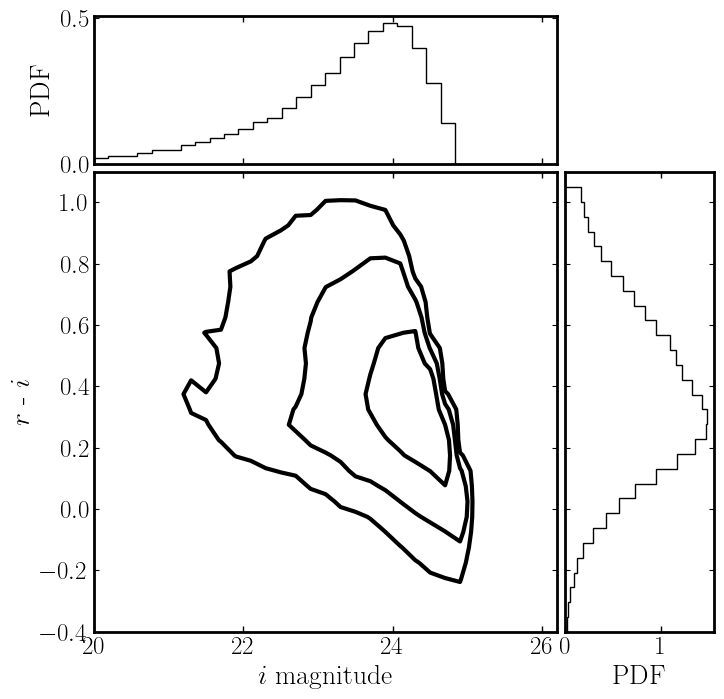

In [48]:
def get_mag(flux):
    return 27.0 - np.log10(flux) * 2.5
    
xrange = [20.0, 26.0]
yrange = [-0.4, 1.1]
xlabel = r'$i$ magnitude'
ylabel = r'$r$ - $i$'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.4, 1.1]
)

    
mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode00/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
ndata = 0
for tract in tracts:
    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    mag_sim_g = get_mag(d["flux_sim_g"])
    mag_sim_r = get_mag(d["flux_sim_r"])
    mag_sim_i = get_mag(d["flux_sim_i"])
    mag_sim_z = get_mag(d["flux_sim_z"])
    mag_sim_y = get_mag(d["flux_sim_y"])
    msk_sim =  (mag_sim_i < mag_lim) & (d["size_sim_i"] > size_lim) & (mag_sim_g < mag_lim2) & (mag_sim_r < mag_lim) & (mag_sim_z < mag_lim) & (mag_sim_y < mag_lim2)
    
    x_array = mag_sim_i[msk_sim]
    y_array = mag_sim_r[msk_sim] - mag_sim_i[msk_sim]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
    ndata += np.sum(msk_sim)
    
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-",  levels=[0.1, 0.3, 0.65])

pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_ri_2d.fits", histxy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_ri_1d-y.fits", histy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_ri_1d-x.fits", histx)

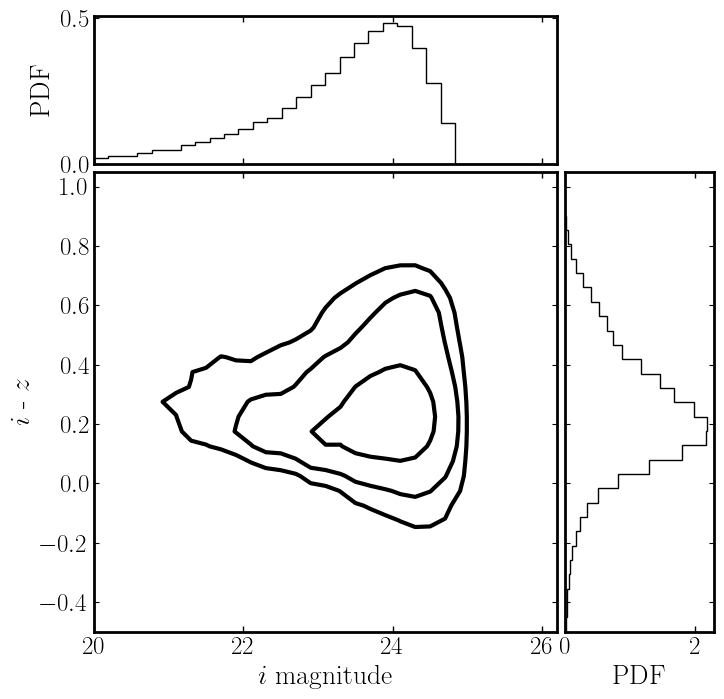

In [91]:
data_all = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/success.fits")
tracts = np.unique(data_all["tract"])
def get_mag(flux):
    return 27.0 - np.log10(flux) * 2.5
    
xrange = [20.0, 26.0]
yrange = [-0.5, 1.0]
xlabel = r'$i$ magnitude'
ylabel = r'$i$ - $z$'
nbins = 30

corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.5, 1.05]
)

    
mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode00/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
for tract in tracts:
    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    mag_sim_g = get_mag(d["flux_sim_g"])
    mag_sim_r = get_mag(d["flux_sim_r"])
    mag_sim_i = get_mag(d["flux_sim_i"])
    mag_sim_z = get_mag(d["flux_sim_z"])
    mag_sim_y = get_mag(d["flux_sim_y"])
    msk_sim =  (mag_sim_i < mag_lim) & (d["size_sim_i"] > size_lim) & (mag_sim_g < mag_lim2) & (mag_sim_r < mag_lim) & (mag_sim_z < mag_lim) & (mag_sim_y < mag_lim2)
    
    x_array = mag_sim_i[msk_sim]
    y_array = mag_sim_i[msk_sim] - mag_sim_z[msk_sim]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
    
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.15, 0.3, 0.65])
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_iz_2d.fits", histxy, overwrite=True)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_iz_1d-y.fits", histy, overwrite=True)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_iz_1d-x.fits", histx, overwrite=True)

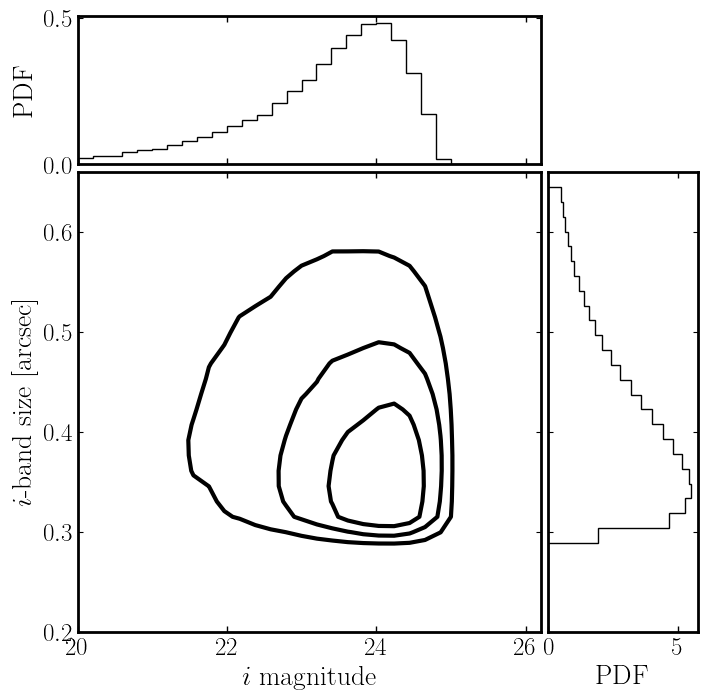

In [50]:
xrange = [20., 26.2]
yrange = [0.2, 0.66]
xlabel = r'$i$ magnitude'
ylabel = r'$i$-band size [arcsec]'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20., 26.2], ylim=[0.2, 0.66]
)

mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode00/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
for tract in tracts:
    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    mag_sim_g = get_mag(d["flux_sim_g"])
    mag_sim_r = get_mag(d["flux_sim_r"])
    mag_sim_i = get_mag(d["flux_sim_i"])
    mag_sim_z = get_mag(d["flux_sim_z"])
    mag_sim_y = get_mag(d["flux_sim_y"])
    msk_sim =  (mag_sim_i < mag_lim) & (d["size_sim_i"] > size_lim) & (mag_sim_g < mag_lim2) & (mag_sim_r < mag_lim) & (mag_sim_z < mag_lim) & (mag_sim_y < mag_lim2)
    
    x_array = mag_sim_i[msk_sim]
    y_array = d["size_sim_i"][msk_sim]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
    
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.1, 0.3, 0.6])
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_isize_2d.fits", histxy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_isize_1d-y.fits", histy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_isize_1d-x.fits", histx)

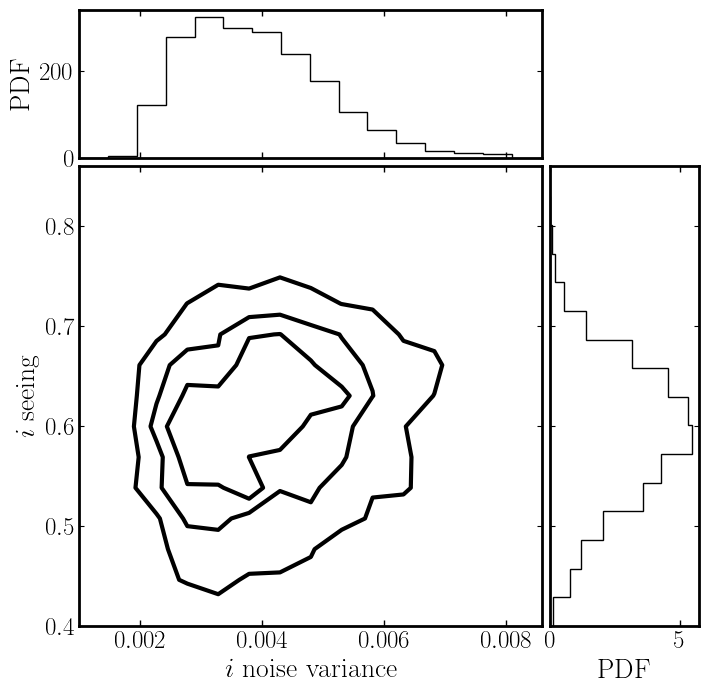

In [51]:
xrange = [1e-3, 8.6e-3]
yrange = [0.4, 0.86]
xlabel = r'$i$ noise variance'
ylabel = r'$i$ seeing'
nbins = 15
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[1e-3, 8.6e-3], ylim=[0.4, 0.86]
)

mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/g1_mode00/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
for tract in tracts:
    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    x_array = d["var_sim_i"]
    y_array = d["fwhm_sim_i"]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
    
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.1, 0.3, 0.5])
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_sys_2d.fits", histxy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_sys_1d-y.fits", histy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_sys_1d-x.fits", histx)

In [ ]:
tracts = np.unique(pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")["tract"])
def get_mag(flux):
    return 27.0 - np.log10(flux) * 2.5
    
xrange = [20.0, 26.0]
yrange = [-0.5, 1.0]
xlabel = r'$i$ magnitude'
ylabel = r'$i$ - $z$'
nbins = 30

corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.5, 1.05]
)

    
mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-galaxy/tracts/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
for tract in tracts:

    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    mag_g = d["forced_g_cmodel_mag"]
    mag_r = d["forced_r_cmodel_mag"]
    mag_i = d["forced_i_cmodel_mag"]
    mag_z = d["forced_z_cmodel_mag"]
    mag_y = d["forced_y_cmodel_mag"]
    size_i = xlens.catalog.basic.get_sdss_size(d)
    msk =  (mag_i < mag_lim) & (size_i > size_lim) & (mag_g < mag_lim2) & (mag_r < mag_lim) & (mag_z < mag_lim) & (mag_y < mag_lim2)
    
    x_array = mag_i[msk]
    y_array = mag_i[msk] - mag_z[msk]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
    
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.15, 0.3, 0.65])
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_iz_2d.fits", histxy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_iz_1d-y.fits", histy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_iz_1d-x.fits", histx)

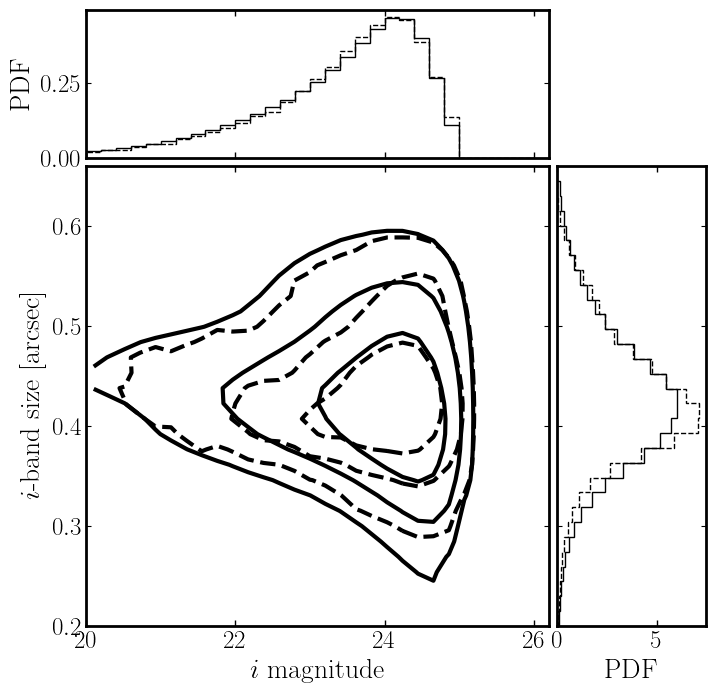

In [92]:
xrange = [20., 26.2]
yrange = [0.2, 0.66]
xlabel = r'$i$ magnitude'
ylabel = r'$i$ - $z$'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20., 26.2], ylim=[0.2, 0.66]
)

histxy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_iz_2d.fits")
histy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_iz_1d-y.fits")
histx = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_iz_1d-x.fits")
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.1, 0.3, 0.6])

histxy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_iz_2d.fits")
histy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_iz_1d-y.fits")
histx = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_iz_1d-x.fits")
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="--", levels=[0.1, 0.3, 0.6])

In [ ]:
tracts = np.unique(pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")["tract"])
def get_mag(flux):
    return 27.0 - np.log10(flux) * 2.5
    
xrange = [20.0, 26.0]
yrange = [-0.4, 1.1]
xlabel = r'$i$ magnitude'
ylabel = r'$r$ - $i$'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.4, 1.1]
)
    
mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-galaxy/tracts/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
for tract in tracts:

    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    mag_g = d["forced_g_cmodel_mag"]
    mag_r = d["forced_r_cmodel_mag"]
    mag_i = d["forced_i_cmodel_mag"]
    mag_z = d["forced_z_cmodel_mag"]
    mag_y = d["forced_y_cmodel_mag"]
    size_i = xlens.catalog.basic.get_sdss_size(d)
    msk =  (mag_i < mag_lim) & (size_i > size_lim) & (mag_g < mag_lim2) & (mag_r < mag_lim) & (mag_z < mag_lim) & (mag_y < mag_lim2)
    
    x_array = mag_i[msk]
    y_array = mag_r[msk] - mag_i[msk]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
    
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.15, 0.3, 0.65])
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_ri_2d.fits", histxy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_ri_1d-y.fits", histy)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_ri_1d-x.fits", histx)

In [6]:
27.0 - np.log10(10) * 2.5

24.5

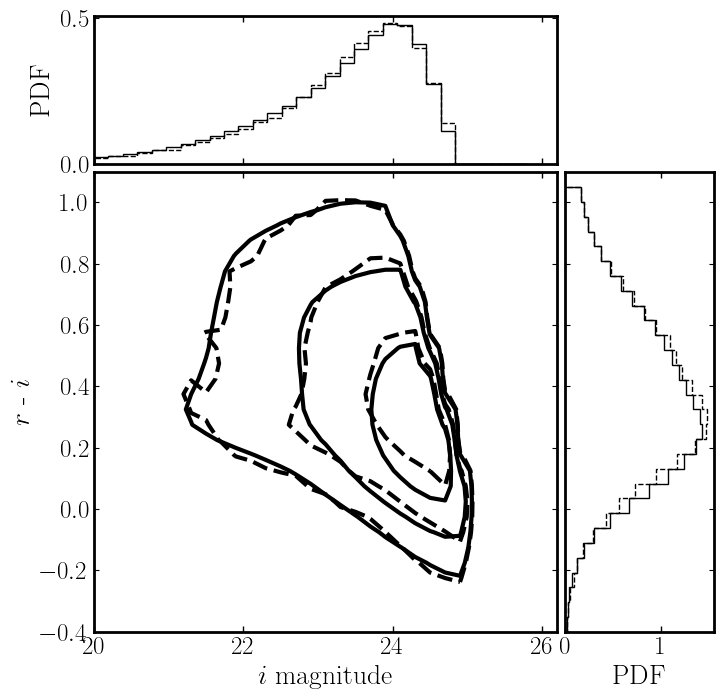

In [97]:
xrange = [20.0, 26.0]
yrange = [-0.4, 1.1]
xlabel = r'$i$ magnitude'
ylabel = r'$r$ - $i$'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.4, 1.1]
)

histxy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_ri_2d.fits")
histy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_ri_1d-y.fits")
histx = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_ri_1d-x.fits")
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.1, 0.3, 0.65])

histxy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_ri_2d.fits")
histy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_ri_1d-y.fits")
histx = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_ri_1d-x.fits")
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="--", levels=[0.1, 0.3, 0.65])

In [ ]:
tracts = np.unique(pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")["tract"])
plt.close()
xrange = [20., 26.2]
yrange = [0.2, 0.66]
xlabel = r'$i$ magnitude'
ylabel = r'$i$-band size [arcsec]'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20., 26.2], ylim=[0.2, 0.66]
)

mag_lim = 25.0
mag_lim2 = 26.0
size_lim = 0.3
sim_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-galaxy/tracts/"
histxy = np.zeros((nbins, nbins))
histx = np.zeros(nbins)
histy = np.zeros(nbins)
for tract in tracts:
    fname = os.path.join(sim_dir, f"{tract}.fits")
    d = pyfits.getdata(fname)
    mag_g = d["forced_g_cmodel_mag"]
    mag_r = d["forced_r_cmodel_mag"]
    mag_i = d["forced_i_cmodel_mag"]
    mag_z = d["forced_z_cmodel_mag"]
    mag_y = d["forced_y_cmodel_mag"]
    size_i = xlens.catalog.basic.get_sdss_size(d)
    msk =  (mag_i < mag_lim) & (size_i > size_lim) & (mag_g < mag_lim2) & (mag_r < mag_lim) & (mag_z < mag_lim) & (mag_y < mag_lim2)
    
    x_array = mag_i[msk]
    y_array = size_i[msk]
    xy, x, y = corp.compute_histograms(x_array, y_array)
    histxy = histxy + xy
    histx = histx + x
    histy = histy + y
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_isize_2d.fits", histxy, overwrite=True)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_isize_1d-y.fits", histy, overwrite=True)
pyfits.writeto("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_isize_1d-x.fits", histx, overwrite=True)

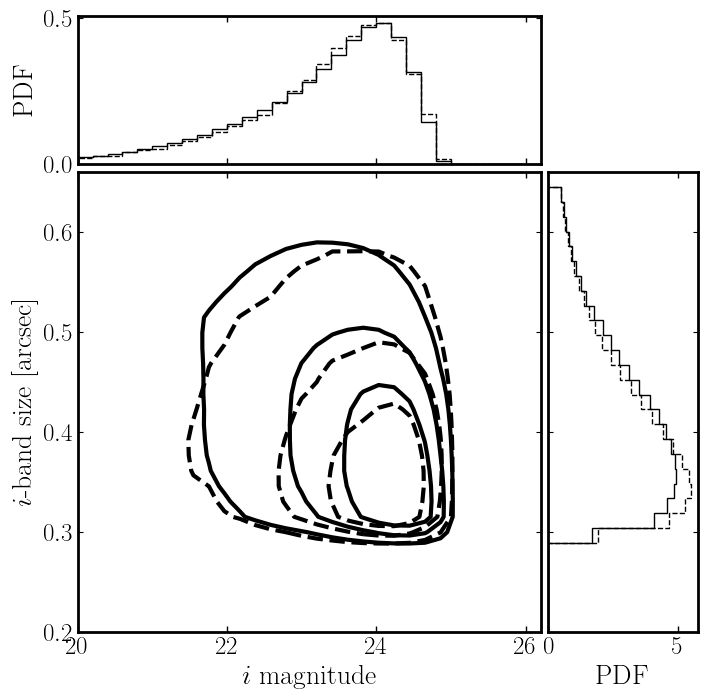

In [4]:
xrange = [20., 26.2]
yrange = [0.2, 0.66]
xlabel = r'$i$ magnitude'
ylabel = r'$i$-band size [arcsec]'
nbins = 30
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=nbins, xlabel=xlabel, ylabel=ylabel,
    xlim=[20., 26.2], ylim=[0.2, 0.66]
)

histxy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_isize_2d.fits")
histy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_isize_1d-y.fits")
histx = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/histograms/hist_isize_1d-x.fits")
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="-", levels=[0.1, 0.3, 0.6])

histxy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_isize_2d.fits")
histy = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_isize_1d-y.fits")
histx = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/sim_v1/histograms/hist_isize_1d-x.fits")
corp.make_plot(hist_2d=histxy, hist_x=histx, hist_y=histy, linestyles="--", levels=[0.1, 0.3, 0.6])

In [1]:
import glob

In [ ]:
fnames = glob.glob("/lustre/work/xiangchong.li/work/hsc_s23b_sim/systematics/20250301T190954Z/deepCoadd_systematics_noisecorr/*/*/i/*.fits")

55


2650

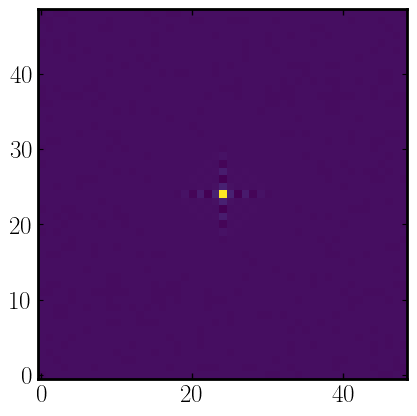

In [84]:
i = 55
print(i)
a=pyfits.getdata(fnames[i])
a = a / np.amax(a)
plt.close()
plt.imshow(a, origin="lower")
gc.collect()

In [22]:
fnames0 = glob.glob("/lustre/work/xiangchong.li/work/hsc_s23b_sim/systematics/20250301T190954Z/deepCoadd_systematics_psfcentered/*/*/i/*.fits")
fnames = glob.glob("/work/xiangchong.li/work/hsc_s23b_sim/test_real_sys/result/20250325T025959Z/simCoadd_anacal_selbias_flux_joint/*/*/*.parq")

In [33]:
tplist0 = set([int(ff.split('/')[-4]) * 1000 +int(ff.split('/')[-3]) for ff in fnames0])
tplist = set([int(ff.split('/')[-3]) * 1000 +int(ff.split('/')[-2]) for ff in fnames])

In [38]:
np.array(list(tplist0 - tplist)) // 1000

array([ 9849, 10665,  9952,  9969, 16004,  9953,  9354,  9703, 10437])

In [39]:
np.array(list(tplist0 - tplist)) % 1000

array([62, 31, 39, 36, 50, 44, 75, 69, 22])

In [18]:
dd =astTable.Table.read(fnames[0])

In [21]:
len(fnames)

5025

In [9]:
len(dd)
plt.close()
plt.hist(dd["flux"], range=(0, 20))

5234

(array([  0.,   0.,  36., 454., 563., 521., 448., 337., 322., 238.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

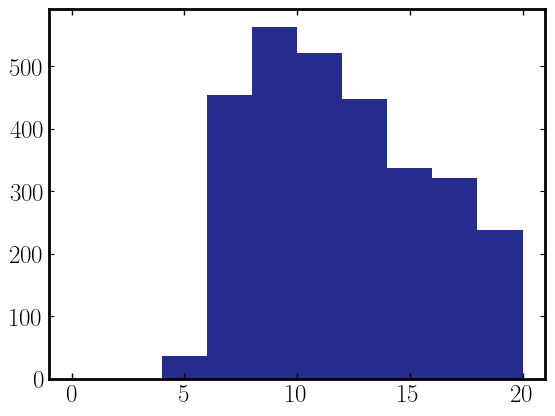